# 1- Initialisation et Chargement de la Dataset

Objectif : installer/configurer PySpark, charger le dataset, vérifier le schéma et le nombre de lignes.


## Q1.1 — Installation de PySpark



In [1]:
!pip -q install pyspark


## Q1.2 — Imports nécessaires pour la question 1
import os
import pandas as pd
from pyspark.sql import SparkSession


In [ ]:
import os
import pandas as pd
from pyspark.sql import SparkSession

Dans cette cellule, nous importons les bibliothèques nécessaires au projet.

- pandas pourra être utilisé si besoin pour certaines manipulations.

- os permet de gérer les fichiers et dossiers.

- SparkSession permet de lancer Spark.

Cette étape prépare l’environnement avant de commencer le traitement des données.

## Q1.3 — Démarrage de Spark


In [ ]:
spark = (SparkSession.builder
         .appName("Projet_Cloud")
         .config("spark.sql.shuffle.partitions", "8")
         .getOrCreate())

spark

Nous démarrons Spark, il va nous permettre de lire le dataset et de traiter les données.
Nous définissons aussi le nom du projet ("Projet_Cloud") et le nombre de partitions pour rendre l’exécution plus stable. On définit aussi le nombre de partitions pour avoir une exécution plus stable.

Sans cette étape, il serait impossible d’utiliser spark.read.

## Q1.4 — Connexion à Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cette cellule permet de connecter notre Google Drive à Colab.
Cela nous permet d’accéder au dataset stocké dans le Drive et d’éviter de perdre les fichiers à la fin de la session.




## Q1.5 — Vérification du fichier dans le dossier


In [ ]:
os.listdir("/content/drive/MyDrive/Projet Cloud")


['Online_Retail_CSV.csv']

Cette cellule permet de vérifier que notre dataset est bien présent dans le dossier "Projet Cloud".
On s’assure que le fichier est accessible avant de le charger avec Spark.



## Q1.6 — Chargement du dataset


In [ ]:
df_raw = (spark.read
          .option("header", "true")
          .option("inferSchema", "true")
          .option("sep", ";")
          .csv("/content/drive/MyDrive/Projet Cloud/Online_Retail_CSV.csv"))

df_raw.printSchema()
df_raw.show(5)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2,55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2,75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNI

Dans cette étape, nous avons chargé le dataset avec Spark en précisant que le séparateur utilisé est ;.
Nous avons également demandé à Spark de détecter automatiquement les types de variables.

Après exécution, nous constatons que :

- Les colonnes sont bien séparées.

- Les variables principales (Quantity, CustomerID, etc.) sont correctement identifiées.

- Le dataset contient plus de 500 000 lignes avant nettoyage.

- Les prix sont encore au format texte avec une virgule, ce qui devra être corrigé par la suite.

Cette étape confirme que le chargement du fichier s’est déroulé correctement et que les données sont prêtes à être préparées pour l’analyse.

## Q1.7 — Vérification de la structure du dataset et le volume de données


In [ ]:
df_raw.printSchema()
df_raw.show(5)

print("Nombre total de lignes (dataset brut) :", df_raw.count())

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2,55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2,75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNI

L’instruction printSchema() affiche la structure des données ainsi que le type de chaque variable. On observe que les colonnes principales sont bien présentes : InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID et Country. Les types semblent cohérents, même si certaines colonnes comme UnitPrice et InvoiceDate sont encore au format texte à ce stade.

La commande show(5) permet d’afficher un aperçu des premières lignes afin de vérifier que les données sont correctement séparées (notamment avec le séparateur ;).

Enfin, le dataset contient 541 909 lignes avant tout nettoyage. Cela confirme que nous travaillons sur un volume de données important, justifiant l’utilisation de PySpark pour le traitement.

# 2- Exploration & Prétraitement
Objectif : analyser la qualité des données (valeurs manquantes / incohérentes), préparer les variables (formats, nettoyage) et produire une première exploration descriptive.


## Q2.1 — Valeurs manquantes



In [ ]:
from pyspark.sql.functions import col, count, when

print("Nombre de valeurs manquantes par colonne (dataset brut) :")

df_raw.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df_raw.columns]
).show()

Nombre de valeurs manquantes par colonne (dataset brut) :
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Cette cellule permet d’identifier le nombre de valeurs manquantes pour chaque colonne du dataset brut, avant toute transformation.

Les résultats montrent que :

- La colonne CustomerID contient 135 080 valeurs manquantes.

- La colonne Description contient 1 454 valeurs manquantes.

- Les autres colonnes ne présentent pas de valeurs nulles.

La présence d’un nombre important de CustomerID manquants pose un problème pour l’analyse client, notamment pour la segmentation future (RFM et clustering). En effet, sans identifiant client, il est impossible d’agréger les achats par individu.

Les valeurs manquantes dans Description sont moins problématiques pour la segmentation, mais elles pourront être ignorées lors des analyses produits.

Cette étape justifie donc la suppression des lignes sans CustomerID lors du nettoyage.

## Q2.2 — Détection des valeurs incohérentes (dataset brut)

 On regarde surtout Quantity <= 0 et UnitPrice <= 0

In [ ]:

from pyspark.sql.functions import regexp_replace, to_timestamp

df_tmp = (df_raw
          .withColumn("UnitPrice_tmp", regexp_replace(col("UnitPrice"), ",", ".").cast("double"))
          .withColumn("InvoiceDate_tmp", to_timestamp(col("InvoiceDate"), "dd/MM/yyyy HH:mm"))
         )

nb_qty_bad = df_tmp.filter(col("Quantity") <= 0).count()
nb_price_bad = df_tmp.filter(col("UnitPrice_tmp") <= 0).count()
nb_date_null = df_tmp.filter(col("InvoiceDate_tmp").isNull()).count()
nb_customer_null = df_tmp.filter(col("CustomerID").isNull()).count()

print("Nombre de lignes avec Quantity <= 0 :", nb_qty_bad)
print("Nombre de lignes avec UnitPrice <= 0 :", nb_price_bad)
print("Nombre de lignes où InvoiceDate ne se convertit pas :", nb_date_null)
print("Nombre de lignes avec CustomerID manquant :", nb_customer_null)


Nombre de lignes avec Quantity <= 0 : 10624
Nombre de lignes avec UnitPrice <= 0 : 2517
Nombre de lignes où InvoiceDate ne se convertit pas : 0
Nombre de lignes avec CustomerID manquant : 135080


Cette cellule permet d’identifier les lignes présentant des valeurs anormales avant nettoyage.

Les résultats montrent que :

- 10 624 lignes ont une Quantity inférieure ou égale à 0.
Ces lignes correspondent généralement à des retours ou à des annulations de commandes.

- 2 517 lignes ont un UnitPrice inférieur ou égal à 0.
Un prix nul ou négatif n’est pas cohérent pour une analyse du chiffre d’affaires.

- Aucune ligne ne pose de problème lors de la conversion de InvoiceDate, ce qui confirme que le format de date est homogène.

- 135 080 lignes ont un CustomerID manquant, ce qui confirme le résultat observé précédemment.

Ces éléments justifient le nettoyage futur du dataset :
les lignes avec CustomerID manquant, Quantity ≤ 0 ou UnitPrice ≤ 0 devront être supprimées afin de garantir la cohérence des analyses.

## Q2.3 — Nettoyage et préparation des données
 1) Conversion des types (UnitPrice en double, InvoiceDate en timestamp)
 2) Suppression des lignes sans CustomerID
 3) Suppression des lignes incohérentes (Quantity <= 0, UnitPrice <= 0)
 4) Création de TotalPrice


In [ ]:
from pyspark.sql.functions import round

df_clean = (df_raw
            .withColumn("UnitPrice", regexp_replace(col("UnitPrice"), ",", ".").cast("double"))
            .withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "dd/MM/yyyy HH:mm"))
            .filter(col("CustomerID").isNotNull())
            .filter(col("InvoiceDate").isNotNull())
            .filter(col("Quantity") > 0)
            .filter(col("UnitPrice") > 0)
            .withColumn("TotalPrice", round(col("Quantity") * col("UnitPrice"), 2))
           )

print("Nombre de lignes (dataset brut) :", df_raw.count())
print("Nombre de lignes (après nettoyage) :", df_clean.count())

df_clean.select("InvoiceNo","CustomerID","Quantity","UnitPrice","TotalPrice","InvoiceDate","Country").show(5)

Nombre de lignes (dataset brut) : 541909
Nombre de lignes (après nettoyage) : 397884
+---------+----------+--------+---------+----------+-------------------+--------------+
|InvoiceNo|CustomerID|Quantity|UnitPrice|TotalPrice|        InvoiceDate|       Country|
+---------+----------+--------+---------+----------+-------------------+--------------+
|   536365|     17850|       6|     2.55|      15.3|2010-12-01 08:26:00|United Kingdom|
|   536365|     17850|       6|     3.39|     20.34|2010-12-01 08:26:00|United Kingdom|
|   536365|     17850|       8|     2.75|      22.0|2010-12-01 08:26:00|United Kingdom|
|   536365|     17850|       6|     3.39|     20.34|2010-12-01 08:26:00|United Kingdom|
|   536365|     17850|       6|     3.39|     20.34|2010-12-01 08:26:00|United Kingdom|
+---------+----------+--------+---------+----------+-------------------+--------------+
only showing top 5 rows


Dans cette étape, nous appliquons le nettoyage du dataset afin de conserver uniquement des données cohérentes et exploitables pour l’analyse.

Plusieurs transformations sont réalisées :

- Conversion de UnitPrice en format numérique (double) après remplacement de la virgule par un point.

- Conversion de InvoiceDate en format timestamp pour permettre les calculs temporels.

- Suppression des lignes sans CustomerID, car elles ne peuvent pas être utilisées pour une analyse client.

- Suppression des lignes où Quantity ≤ 0 ou UnitPrice ≤ 0, car elles correspondent à des retours ou à des valeurs incohérentes.

- Création de la variable TotalPrice, calculée comme Quantity × UnitPrice, qui sera essentielle pour la variable Monetary lors de la segmentation RFM.

Le dataset passe de 541 909 lignes à 397 884 lignes après nettoyage.
Cela signifie qu’environ 26 % des lignes ont été supprimées, principalement en raison de l’absence de CustomerID ou de valeurs incohérentes.

Le dataset nettoyé (df_clean) est désormais prêt pour l’analyse exploratoire approfondie et les étapes de modélisation.

## Q2.4 — Vue globale après nettoyage (volume, clients, pays, période)

In [ ]:
from pyspark.sql.functions import min, max, countDistinct

total_transactions = df_clean.count()
total_clients = df_clean.select(countDistinct("CustomerID")).collect()[0][0]
total_countries = df_clean.select(countDistinct("Country")).collect()[0][0]

print("Nombre total de transactions (après nettoyage) :", total_transactions)
print("Nombre de clients distincts :", total_clients)
print("Nombre de pays distincts :", total_countries)

df_clean.select(
    min("InvoiceDate").alias("Première date"),
    max("InvoiceDate").alias("Dernière date")
).show()


Nombre total de transactions (après nettoyage) : 397884
Nombre de clients distincts : 4338
Nombre de pays distincts : 37
+-------------------+-------------------+
|      Première date|      Dernière date|
+-------------------+-------------------+
|2010-12-01 08:26:00|2011-12-09 12:50:00|
+-------------------+-------------------+



Après application des étapes de nettoyage, le dataset contient désormais 397 884 transactions valides, contre 541 909 initialement. Cela confirme que les lignes présentant des valeurs manquantes ou incohérentes ont bien été supprimées.

Le dataset comprend 4 338 clients distincts, ce qui constitue une base client suffisamment large pour réaliser une analyse comportementale pertinente.

Les transactions proviennent de 37 pays différents, ce qui montre que l’activité est internationale, même si certains pays peuvent dominer en volume.

La période couverte s’étend du 1er décembre 2010 au 9 décembre 2011, soit environ une année complète d’activité. Cette durée est adaptée pour analyser les comportements d’achat sur le moyen terme et préparer une future segmentation client.

Cette vue globale confirme que le dataset nettoyé est cohérent, structuré et prêt pour une analyse descriptive approfondie.

## Q2.5 — Statistiques descriptives (Quantity, UnitPrice, TotalPrice)

In [ ]:
df_clean.select("Quantity","UnitPrice","TotalPrice").describe().show()


+-------+------------------+------------------+------------------+
|summary|          Quantity|         UnitPrice|        TotalPrice|
+-------+------------------+------------------+------------------+
|  count|            397884|            397884|            397884|
|   mean|12.988237777844798| 3.116487755225661|22.396999879364532|
| stddev|179.33177496319988|22.097876630867937|309.07104141474707|
|    min|                 1|             0.001|               0.0|
|    max|             80995|           8142.75|          168469.6|
+-------+------------------+------------------+------------------+



Les statistiques descriptives permettent d’analyser la distribution des principales variables quantitatives du dataset nettoyé.

La quantité moyenne achetée est d’environ 13 unités par transaction, avec un minimum de 1 et un maximum très élevé de 80 995 unités. L’écart-type important confirme une forte dispersion des quantités, ce qui suggère la présence d’achats en gros.

Le prix unitaire moyen est d’environ 3.12, mais le maximum atteint 8 142.75. La différence importante entre la moyenne et le maximum indique une distribution très asymétrique, avec quelques produits très chers.

Concernant la variable TotalPrice, la moyenne est d’environ 22.40, tandis que le maximum atteint 168 469.60. Cela montre que certaines transactions représentent des montants très élevés, probablement liés à des commandes importantes en volume ou en valeur.

Ces résultats confirment la présence de valeurs extrêmes dans les données. Toutefois, ces valeurs ne sont pas nécessairement des erreurs : elles peuvent correspondre à des clients professionnels ou à des achats en grande quantité. Il faudra en tenir compte lors des étapes de modélisation et de segmentation.

## Q2.6 — Quantiles
Objectif : pour repérer les valeurs extrêmes

In [ ]:
q_qty = df_clean.approxQuantile("Quantity", [0.25,0.5,0.75,0.90,0.95,0.99], 0.01)
q_price = df_clean.approxQuantile("UnitPrice", [0.25,0.5,0.75,0.90,0.95,0.99], 0.01)

print("Quantiles Quantity (25%, 50%, 75%, 90%, 95%, 99%) :", q_qty)
print("Quantiles UnitPrice (25%, 50%, 75%, 90%, 95%, 99%) :", q_price)


Quantiles Quantity (25%, 50%, 75%, 90%, 95%, 99%) : [2.0, 6.0, 12.0, 24.0, 36.0, 80995.0]
Quantiles UnitPrice (25%, 50%, 75%, 90%, 95%, 99%) : [1.25, 1.95, 3.75, 6.25, 8.5, 8142.75]


Les quantiles permettent d’analyser plus précisément la distribution des variables et d’identifier la présence éventuelle de valeurs extrêmes.

Pour la variable Quantity :

- 25 % des transactions concernent au plus 2 unités.

- 50 % (médiane) concernent au plus 6 unités.

- 75 % concernent au plus 12 unités.

- 90 % concernent au plus 24 unités.

- 95 % concernent au plus 36 unités.

Le maximum est de 80 995 unités.

On observe que la grande majorité des transactions portent sur de petites quantités. La valeur maximale est très éloignée du reste de la distribution, ce qui confirme qu’il s’agit d’un cas exceptionnel.

Pour la variable UnitPrice :

- 25 % des produits coûtent moins de 1.25.

- 50 % coûtent moins de 1.95.

- 75 % coûtent moins de 3.75.

- 90 % coûtent moins de 6.25.

- 95 % coûtent moins de 8.5.

Le maximum est de 8 142.75.

Là encore, la majorité des produits ont un prix relativement faible, et les prix très élevés sont rares.

Ces résultats montrent que les distributions sont fortement asymétriques. Les valeurs extrêmes existent, mais elles concernent une proportion très faible des données. Il est donc cohérent de les conserver, tout en gardant à l’esprit leur impact potentiel lors des étapes de modélisation.

On peut maintenant passer à Q2.7 (Top pays) pour finaliser la partie descriptive de la Question 2.

## Q2.7 — Top 10 pays par nombre de lignes



In [ ]:
df_clean.groupBy("Country").count().orderBy(col("count").desc()).show(10)


+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|354321|
|       Germany|  9040|
|        France|  8341|
|          EIRE|  7236|
|         Spain|  2484|
|   Netherlands|  2359|
|       Belgium|  2031|
|   Switzerland|  1841|
|      Portugal|  1462|
|     Australia|  1182|
+--------------+------+
only showing top 10 rows


Le classement des pays par nombre de lignes d’achats montre une très forte concentration des transactions au Royaume-Uni, avec plus de 354 000 lignes. Ce volume est largement supérieur aux autres pays.

Les pays suivants (Allemagne, France, EIRE, Espagne, Pays-Bas, etc.) représentent des volumes bien plus faibles, généralement inférieurs à 10 000 lignes chacun.

Cela indique que l’activité de l’entreprise est principalement centrée sur le Royaume-Uni, même si elle possède une présence internationale dans 37 pays.

Cette forte concentration géographique devra être prise en compte dans les analyses futures, notamment lors de la segmentation client, car les comportements d’achat peuvent être influencés par le pays.

## Q2.8 — Top 10 produits les plus vendus (en quantité totale)


In [ ]:
import pyspark.sql.functions as F

df_clean.filter(F.col("Description").isNotNull()) \
    .groupBy("Description") \
    .agg(F.sum("Quantity").alias("Quantite_Totale")) \
    .orderBy(F.col("Quantite_Totale").desc()) \
    .show(10, truncate=False)


+----------------------------------+---------------+
|Description                       |Quantite_Totale|
+----------------------------------+---------------+
|PAPER CRAFT , LITTLE BIRDIE       |80995          |
|MEDIUM CERAMIC TOP STORAGE JAR    |77916          |
|WORLD WAR 2 GLIDERS ASSTD DESIGNS |54415          |
|JUMBO BAG RED RETROSPOT           |46181          |
|WHITE HANGING HEART T-LIGHT HOLDER|36725          |
|ASSORTED COLOUR BIRD ORNAMENT     |35362          |
|PACK OF 72 RETROSPOT CAKE CASES   |33693          |
|POPCORN HOLDER                    |30931          |
|RABBIT NIGHT LIGHT                |27202          |
|MINI PAINT SET VINTAGE            |26076          |
+----------------------------------+---------------+
only showing top 10 rows


Cette requête permet d’identifier les 10 produits les plus vendus en termes de quantité totale.

On commence par supprimer les descriptions nulles pour éviter les erreurs, puis on regroupe les données par produit (Description).
Ensuite, on calcule la quantité totale vendue pour chaque produit avec sum("Quantity"), puis on classe les résultats par ordre décroissant.

On observe que "PAPER CRAFT , LITTLE BIRDIE" est le produit le plus vendu avec 80 995 unités.
Les autres produits du top 10 ont également des volumes très élevés.

Cela montre que certaines références dominent largement les ventes.
Ces produits peuvent être considérés comme des produits phares, ce qui pourra être utile plus tard pour des recommandations marketing ou pour analyser le comportement d’achat des clients.

# 3- Segmentation Client (Non supervisé)

## Q3.1 — Création des variables RFM

### Etape 1: Définir une date de référence


In [ ]:
from pyspark.sql.functions import max, datediff, col, countDistinct, sum

# Date de référence = dernière date du dataset
reference_date = df_clean.select(max("InvoiceDate")).collect()[0][0]

print("Date de référence :", reference_date)

Date de référence : 2011-12-09 12:50:00


Ça correspond à la dernière transaction du dataset.

On va utiliser cette date pour calculer la Recency :

Recency =
(nombre de jours entre la date de référence et la dernière commande du client)

Donc :

- Si un client a commandé le 8 décembre 2011 → Recency = 1 jour

- Si un client a commandé en janvier 2011 → Recency sera élevé

Plus la Recency est faible → plus le client est récent.

### Etape 2: Calcul des variables RFM

In [ ]:
from pyspark.sql.functions import col, max, datediff, countDistinct, sum, lit, round

# Date de référence = dernière date du dataset nettoyé
reference_date = df_clean.select(max("InvoiceDate")).collect()[0][0]
print("Date de référence :", reference_date)

# Calcul RFM (1 ligne par client)
rfm = (df_clean
       .groupBy("CustomerID")
       .agg(
           datediff(lit(reference_date), max(col("InvoiceDate"))).alias("Recency"),
           countDistinct(col("InvoiceNo")).alias("Frequency"),
           round(sum(col("TotalPrice")), 2).alias("Monetary")
       )
)

rfm.show(5)
print("Nombre de clients dans le RFM :", rfm.count())


Date de référence : 2011-12-09 12:50:00
+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     17420|     50|        3|  598.83|
|     17850|    372|       34| 5391.21|
|     16552|    242|        2|  379.73|
|     15350|    373|        1|  115.65|
|     12921|      9|       37|16587.09|
+----------+-------+---------+--------+
only showing top 5 rows
Nombre de clients dans le RFM : 4338


Cette cellule construit les variables RFM à partir du dataset nettoyé df_clean, avec une ligne par client. La date de référence correspond à la dernière date de transaction disponible dans le dataset (2011-12-09).

- Recency mesure le nombre de jours depuis la dernière commande du client (plus la valeur est faible, plus le client a acheté récemment).

- Frequency correspond au nombre de commandes distinctes réalisées par le client (nombre de InvoiceNo différents).

- Monetary représente le total dépensé par le client (somme de TotalPrice).
On obtient 4338 clients, ce qui est cohérent avec le nombre de clients distincts observé après nettoyage.

## Q3.2 — Assembler + StandardScaler

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# On assemble les 3 variables RFM dans une seule colonne "features"
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features"
)

rfm_features = assembler.transform(rfm)

# Standardisation (centrer-réduire) pour mettre les variables sur la même échelle
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(rfm_features)
rfm_scaled = scaler_model.transform(rfm_features)

rfm_scaled.select("CustomerID", "Recency", "Frequency", "Monetary", "scaledFeatures").show(5, truncate=False)


+----------+-------+---------+--------+---------------------------------------------------------------+
|CustomerID|Recency|Frequency|Monetary|scaledFeatures                                                 |
+----------+-------+---------+--------+---------------------------------------------------------------+
|17420     |50     |3        |598.83  |[-0.42054316769109856,-0.16523968726395555,-0.1619089051818419]|
|17850     |372    |34       |5391.21 |[2.799061972152176,3.8617814551576104,0.3712157077902933]      |
|16552     |242    |2        |379.73  |[1.4992213877434009,-0.29514359508400606,-0.18628251551787425] |
|15350     |373    |1        |115.65  |[2.8090607458783974,-0.4250475029040566,-0.21565989122549373]  |
|12921     |9      |37       |16587.09|[-0.8304928904661739,4.251493178617762,1.6166927342119186]     |
+----------+-------+---------+--------+---------------------------------------------------------------+
only showing top 5 rows


Dans cette étape, les trois variables RFM (Recency, Frequency, Monetary) ont été regroupées dans une seule colonne features grâce à VectorAssembler.

Ensuite, on applique une standardisation avec StandardScaler. Cela permet de centrer et réduire les variables, afin qu’elles soient comparables entre elles. Sans cette étape, la variable Monetary (qui a des valeurs beaucoup plus élevées) pourrait dominer le clustering.

Dans le résultat affiché, on observe la nouvelle colonne scaledFeatures.
Les valeurs sont désormais centrées autour de 0 :

- Une valeur positive signifie que le client est au-dessus de la moyenne sur cette dimension.

- Une valeur négative signifie qu’il est en dessous de la moyenne.

Cette transformation est essentielle pour garantir un clustering équilibré et cohérent.

## Q3.3 — Assembler et standardiser (VectorAssembler + StandardScaler)

### Etape 1: VectorAssembler

In [ ]:
from pyspark.ml.feature import VectorAssembler

# On regroupe R, F, M dans un seul vecteur de features
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features"
)

rfm_features = assembler.transform(rfm)
rfm_features.select("CustomerID", "Recency", "Frequency", "Monetary", "features").show(5, truncate=False)


+----------+-------+---------+--------+--------------------+
|CustomerID|Recency|Frequency|Monetary|features            |
+----------+-------+---------+--------+--------------------+
|17420     |50     |3        |598.83  |[50.0,3.0,598.83]   |
|17850     |372    |34       |5391.21 |[372.0,34.0,5391.21]|
|16552     |242    |2        |379.73  |[242.0,2.0,379.73]  |
|15350     |373    |1        |115.65  |[373.0,1.0,115.65]  |
|12921     |9      |37       |16587.09|[9.0,37.0,16587.09] |
+----------+-------+---------+--------+--------------------+
only showing top 5 rows


Dans cette étape, nous avons utilisé VectorAssembler pour regrouper les trois variables RFM (Recency, Frequency, Monetary) dans un seul vecteur appelé features.

Les algorithmes de machine learning dans Spark ne travaillent pas avec des colonnes séparées, mais avec un vecteur numérique unique.
C’est pour cela que nous devons transformer les trois variables en une seule colonne de type vecteur.

Dans le tableau affiché :

- On observe les valeurs individuelles de Recency, Frequency et Monetary.

- La colonne features contient ces trois valeurs regroupées sous la forme :
[Recency, Frequency, Monetary].

Par exemple :

- [50.0, 3.0, 598.83] signifie que ce client a :

- 50 jours de récence,

- 3 commandes,

- 598.83 de montant total dépensé.

À ce stade, les variables sont prêtes pour la standardisation, qui permettra de les mettre sur la même échelle avant le clustering.

### Etape 2: StandardScaler

In [ ]:
from pyspark.ml.feature import StandardScaler

# On standardise les variables (moyenne 0, écart-type 1)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(rfm_features)
rfm_scaled = scaler_model.transform(rfm_features)

rfm_scaled.select("CustomerID", "scaledFeatures").show(5, truncate=False)


+----------+---------------------------------------------------------------+
|CustomerID|scaledFeatures                                                 |
+----------+---------------------------------------------------------------+
|17420     |[-0.42054316769109856,-0.16523968726395555,-0.1619089051818419]|
|17850     |[2.799061972152176,3.8617814551576104,0.3712157077902933]      |
|16552     |[1.4992213877434009,-0.29514359508400606,-0.18628251551787425] |
|15350     |[2.8090607458783974,-0.4250475029040566,-0.21565989122549373]  |
|12921     |[-0.8304928904661739,4.251493178617762,1.6166927342119186]     |
+----------+---------------------------------------------------------------+
only showing top 5 rows


Dans cette étape, nous avons appliqué un StandardScaler sur le vecteur features contenant Recency, Frequency et Monetary.

La standardisation permet de :

- Centrer les variables autour de 0

- Avoir un écart-type égal à 1

- Mettre toutes les variables sur la même échelle

Cela est essentiel car les montants (Monetary) sont beaucoup plus élevés que Recency ou Frequency. Sans cette transformation, le clustering serait principalement influencé par la variable Monetary.

Dans le tableau affiché (scaledFeatures) :

- Une valeur positive signifie que le client est au-dessus de la moyenne sur cette variable.

- Une valeur négative signifie qu’il est en dessous de la moyenne.

- Plus la valeur est éloignée de 0, plus le client est atypique sur cette dimension.

Les données sont maintenant correctement préparées pour appliquer l’algorithme de clustering.

## Q3.4 — Clustering et choix du nombre optimal de clusters

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import mean, count, round, col

evaluator = ClusteringEvaluator(
    predictionCol="prediction",
    featuresCol="scaledFeatures",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

best_k = None
best_silhouette = -float("inf")
best_model = None

print("Recherche du meilleur k (BisectingKMeans)...")

# Test de k = 2 à 7 (tu peux ajuster)
for k in range(2, 8):

    bkm = BisectingKMeans(featuresCol="scaledFeatures", k=k, seed=42)
    model = bkm.fit(rfm_scaled)
    predictions = model.transform(rfm_scaled)

    # Vérifier le nombre réel de clusters créés
    num_distinct_clusters = predictions.select("prediction").distinct().count()
    print(f"k = {k} -> {num_distinct_clusters} clusters distincts générés.")

    # Silhouette seulement si >1 cluster
    if num_distinct_clusters > 1:
        silhouette = evaluator.evaluate(predictions)
        print(f"   Silhouette = {silhouette:.4f}")

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k
            best_model = model
    else:
        print("   On ne calcule pas la silhouette (un seul cluster).")

if best_k is not None:
    print(f"\n=> Meilleur k = {best_k} (Silhouette = {best_silhouette:.4f})")

    # Clusters finaux
    df_clusters = best_model.transform(rfm_scaled)

    # Profil moyen par cluster (sur les variables RFM non standardisées)
    profils_clusters = df_clusters.groupBy("prediction").agg(
        count("CustomerID").alias("Nb_Clients"),
        round(mean("Recency"), 0).alias("Moy_Recency_Jours"),
        round(mean("Frequency"), 2).alias("Moy_Frequency"),
        round(mean("Monetary"), 2).alias("Moy_Monetary_Euros")
    ).orderBy("prediction")

    profils_clusters.show()

else:
    print("\nImpossible de trouver un k valide avec plus d'un cluster.")


Recherche du meilleur k (BisectingKMeans)...
k = 2 -> 2 clusters distincts générés.
   Silhouette = 0.4653
k = 3 -> 3 clusters distincts générés.
   Silhouette = 0.7452
k = 4 -> 4 clusters distincts générés.
   Silhouette = 0.5706
k = 5 -> 5 clusters distincts générés.
   Silhouette = 0.6850
k = 6 -> 6 clusters distincts générés.
   Silhouette = 0.5528
k = 7 -> 7 clusters distincts générés.
   Silhouette = 0.5554

=> Meilleur k = 3 (Silhouette = 0.7452)
+----------+----------+-----------------+-------------+------------------+
|prediction|Nb_Clients|Moy_Recency_Jours|Moy_Frequency|Moy_Monetary_Euros|
+----------+----------+-----------------+-------------+------------------+
|         0|      3205|             40.0|          4.7|           1878.53|
|         1|        26|              5.0|        66.42|          85904.35|
|         2|      1107|            244.0|         1.58|            593.67|
+----------+----------+-----------------+-------------+------------------+



Nous avons testé plusieurs valeurs de k (de 2 à 7) à l’aide de l’algorithme BisectingKMeans afin de déterminer le nombre optimal de clusters.

Les scores de Silhouette obtenus montrent que la meilleure valeur est k = 3, avec un score de 0.7452.
Ce score relativement élevé indique que les clusters sont bien séparés et que la segmentation est pertinente.

Nous retenons donc 3 segments clients pour l’analyse.


Analyse des segments obtenus:

Cluster 0:

Le cluster 0 regroupe 3205 clients.
Ces clients ont une récence moyenne de 40 jours, une fréquence moyenne de 4,7 commandes et une dépense moyenne d’environ 1878 €.

Ce segment correspond à des clients actifs et réguliers. Ils commandent plusieurs fois et génèrent un chiffre d’affaires significatif. Ce sont des clients importants qu’il faut fidéliser.

Cluster 1:

Le cluster 1 est composé de seulement 26 clients.
Ces clients présentent une récence très faible (5 jours en moyenne), une fréquence très élevée (66 commandes en moyenne) et une dépense moyenne extrêmement importante (85 904 €).

Ce segment représente des clients à très forte valeur. Ce sont probablement des clients professionnels ou très fidèles. Ils constituent un segment stratégique pour l’entreprise.

Cluster 2:

Le cluster 2 regroupe 1107 clients.
Ces clients ont une récence moyenne élevée (244 jours), une fréquence faible (1,58 commande en moyenne) et une dépense moyenne plus faible (593 €).

Ce segment correspond à des clients peu actifs ou dormants. Ils n’ont pas commandé depuis longtemps et présentent un faible engagement.

## Q3.5 — Interprétation des segments et recommandations stratégiques

À partir du clustering obtenu, nous avons identifié trois segments de clients aux comportements distincts.
L’objectif est maintenant d’interpréter ces groupes et de proposer des actions concrètes adaptées à chaque profil.


Segment 1 — Clients à très forte valeur (Cluster 1)

Ce segment regroupe un petit nombre de clients, mais avec une fréquence d’achat très élevée et un niveau de dépense extrêmement important. Leur récence faible indique qu’ils sont toujours actifs.

Il s’agit de clients stratégiques pour l’entreprise, probablement des clients professionnels ou très fidèles.

Actions recommandées :

- Mettre en place un programme VIP ou premium

- Proposer des offres personnalisées

- Accorder des avantages exclusifs (réductions, livraison prioritaire, support dédié)

- Mettre en place un suivi commercial spécifique

L’objectif est de maximiser leur fidélisation et d’augmenter encore leur valeur à long terme.


Segment 2 — Clients actifs et réguliers (Cluster 0)

Ce segment constitue la majorité des clients.
Ils commandent régulièrement et génèrent un chiffre d’affaires significatif.

Ils représentent la base stable de l’entreprise.

Actions recommandées :

- Proposer des programmes de fidélité

- Envoyer des promotions ciblées

- Mettre en place du cross-selling ou up-selling

- Relancer les clients après un certain délai d’inactivité

L’objectif est de transformer une partie de ce segment en clients à très forte valeur.

Segment 3 — Clients peu actifs ou dormants (Cluster 2)

Ce segment regroupe des clients ayant une récence élevée, une faible fréquence et un montant dépensé limité.

Ils semblent peu engagés et risquent de ne plus acheter.

Actions recommandées :

- Campagnes de réactivation (email marketing, codes promotionnels)

- Offres de retour (réduction sur prochaine commande)

- Communication ciblée sur des nouveautés ou produits populaires

L’objectif est de réactiver ces clients et d’éviter leur perte définitive.

Conclusion de la segmentation

La segmentation RFM combinée à un algorithme de clustering permet d’identifier des profils clients clairement distincts.
Cette approche fournit une base solide pour adapter la stratégie marketing et améliorer la performance commerciale.

# 4 - Modélisation Supervisée

##  Q4.1 — Définir le label avec un quantile

###  Étape 1 — Calculer le seuil

In [ ]:
# Calcul du 75e percentile de Monetary
seuil = rfm.approxQuantile("Monetary", [0.75], 0.01)[0]

print("Seuil HighSpender (75e percentile) :", seuil)


Seuil HighSpender (75e percentile) : 1624.05


Afin de définir objectivement la variable cible, nous utilisons le 75e percentile de la variable Monetary.

Le seuil obtenu est de 1624.05 €.

Les clients dont le montant total dépensé est supérieur à ce seuil sont classés comme "HighSpender" (1), tandis que les autres sont classés comme "Non-HighSpender" (0).

Cette méthode permet d’éviter un seuil arbitraire et d’adapter la classification à la distribution réelle des données.

### Étape 2 — Créer la variable cible

In [ ]:
from pyspark.sql.functions import when, col

rfm_supervised = rfm.withColumn(
    "HighSpender",
    when(col("Monetary") > seuil, 1).otherwise(0)
)

rfm_supervised.select("CustomerID", "Monetary", "HighSpender").show(5)


+----------+--------+-----------+
|CustomerID|Monetary|HighSpender|
+----------+--------+-----------+
|     17850| 5391.21|          1|
|     17420|  598.83|          0|
|     15862|  832.88|          0|
|     14045| 1659.75|          1|
|     13694|65039.62|          1|
+----------+--------+-----------+
only showing top 5 rows


Dans cette étape, nous avons créé la variable cible HighSpender.
Un client est classé comme gros dépensier (1) si son montant total dépensé (Monetary) est supérieur au seuil défini précédemment (75e percentile), sinon il est classé comme petit dépensier (0).

Cette variable binaire servira de label pour entraîner un modèle de classification supervisée.

In [ ]:
rfm_supervised.groupBy("HighSpender").count().show()


+-----------+-----+
|HighSpender|count|
+-----------+-----+
|          1| 1109|
|          0| 3229|
+-----------+-----+



La répartition des classes montre que 1109 clients (environ 25 %) sont classés comme "HighSpender", tandis que 3229 clients (environ 75 %) sont classés comme "Non-HighSpender".

Cette distribution est cohérente avec l’utilisation du 75e percentile comme seuil.
Le déséquilibre reste raisonnable et permet d’entraîner un modèle de classification sans ajustement particulier.

## Q4.2 — Séparation train / test (70% / 30%)

In [ ]:
train_data, test_data = rfm_supervised.randomSplit([0.7, 0.3], seed=42)

print("Nombre d'observations - Train :", train_data.count())
print("Nombre d'observations - Test :", test_data.count())


Nombre d'observations - Train : 3102
Nombre d'observations - Test : 1236


Nous avons divisé le dataset en deux parties :

- 70 % des données pour l’entraînement du modèle (train)

- 30 % des données pour l’évaluation des performances (test)

Cette séparation permet d’entraîner le modèle sur un sous-ensemble des données, puis d’évaluer sa capacité de généralisation sur des données jamais vues.

Le split obtenu est cohérent avec la proportion attendue (environ 70/30).

## Q4.3 — VectorAssembler (Supervisé)

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features"
)

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

train_data.select("features", "HighSpender").show(5, truncate=False)


+-------------------+-----------+
|features           |HighSpender|
+-------------------+-----------+
|[325.0,1.0,77183.6]|1          |
|[2.0,7.0,4310.0]   |1          |
|[18.0,1.0,1757.55] |1          |
|[310.0,1.0,334.4]  |0          |
|[36.0,8.0,2506.04] |1          |
+-------------------+-----------+
only showing top 5 rows


Dans cette étape, nous avons utilisé VectorAssembler afin de regrouper les variables explicatives (Recency, Frequency et Monetary) dans un vecteur unique appelé features.

Les algorithmes de machine learning dans Spark nécessitent que les variables d’entrée soient regroupées sous forme de vecteur. Cette transformation est donc indispensable avant d’entraîner un modèle supervisé.

Le tableau affiché confirme que chaque observation contient désormais :

- Un vecteur features regroupant les trois variables

- La variable cible HighSpender

Les données sont maintenant prêtes pour l’entraînement du modèle de classification.

## Q4.4 — Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="HighSpender"
)

lr_model = lr.fit(train_data)

predictions_lr = lr_model.transform(test_data)

predictions_lr.select("HighSpender", "prediction", "probability").show(5, truncate=False)


+-----------+----------+-----------+
|HighSpender|prediction|probability|
+-----------+----------+-----------+
|1          |1.0       |[0.0,1.0]  |
|0          |0.0       |[1.0,0.0]  |
|0          |0.0       |[1.0,0.0]  |
|1          |1.0       |[0.0,1.0]  |
|1          |1.0       |[0.0,1.0]  |
+-----------+----------+-----------+
only showing top 5 rows


Dans cette étape, nous avons entraîné un modèle de régression logistique afin de prédire si un client est un HighSpender (1) ou non (0).

Le modèle est entraîné sur le jeu d’entraînement (train_data) à partir des variables RFM regroupées dans features.

Nous appliquons ensuite le modèle sur le jeu de test (test_data) pour obtenir :

- HighSpender : la vraie classe

- prediction : la classe prédite par le modèle

- probability : la probabilité estimée pour chaque classe

Les premières lignes montrent que le modèle prédit correctement plusieurs observations (la valeur prédite correspond à la vraie valeur).

Le modèle semble déjà bien séparer les clients gros dépensiers des autres.

## Q4.5 — Évaluation du modèle

Nous avons choisi une approche de classification. Les métriques RMSE, MAE et R² ne sont donc pas pertinentes ici car elles concernent les modèles de régression.

In [ ]:
import pyspark.sql.functions as F
import builtins
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# On crée une colonne label en double (recommandé pour Spark)
predictions_lr_eval = predictions_lr.withColumn(
    "label",
    F.col("HighSpender").cast("double")
)

# Accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

accuracy = evaluator_accuracy.evaluate(predictions_lr_eval)
f1 = evaluator_f1.evaluate(predictions_lr_eval)
precision = evaluator_precision.evaluate(predictions_lr_eval)
recall = evaluator_recall.evaluate(predictions_lr_eval)

print("Accuracy :", builtins.round(accuracy, 4))
print("Precision :", builtins.round(precision, 4))
print("Recall :", builtins.round(recall, 4))
print("F1-score :", builtins.round(f1, 4))


Accuracy : 0.9992
Precision : 0.9992
Recall : 0.9992
F1-score : 0.9992


Nous évaluons ici les performances du modèle de régression logistique sur le jeu de test.

Les métriques obtenues sont :
- Accuracy : 0.9992
- Precision : 0.9992
- Recall : 0.9992
- F1-score : 0.9992

Ces résultats sont extrêmement élevés, ce qui signifie que le modèle classe presque parfaitement les clients en "HighSpender" et "non HighSpender".

La précision élevée indique que lorsque le modèle prédit qu’un client est un gros dépensier, il se trompe très rarement.  
Le recall élevé montre que le modèle identifie correctement presque tous les gros dépensiers.  
Le F1-score confirme l’équilibre entre précision et rappel.

Le modèle semble donc très performant sur ce jeu de données.


###  Matrice de confusion


In [ ]:
confusion_matrix = predictions_lr_eval.groupBy("label", "prediction").count()

confusion_matrix.orderBy("label", "prediction").show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  906|
|  1.0|       0.0|    1|
|  1.0|       1.0|  329|
+-----+----------+-----+



La matrice de confusion montre que le modèle classe correctement la quasi-totalité des clients.

On observe 906 vrais négatifs et 329 vrais positifs, pour seulement 1 erreur (un faux négatif).

Le modèle ne génère aucun faux positif.
Cela confirme les très bonnes performances obtenues avec les métriques accuracy, precision, recall et F1.
Le modèle est donc extrêmement performant pour identifier les clients à forte valeur.

Les performances très élevées peuvent s’expliquer par le fait que la variable cible HighSpender est directement construite à partir de la variable Monetary, qui est elle-même utilisée comme feature dans le modèle. Cela rend la tâche de classification relativement simple.

# 5- Visualisations & Recommandations

##  5.1 — Visualisations du clustering

###  Graphique 1 : Répartition des clients par cluster

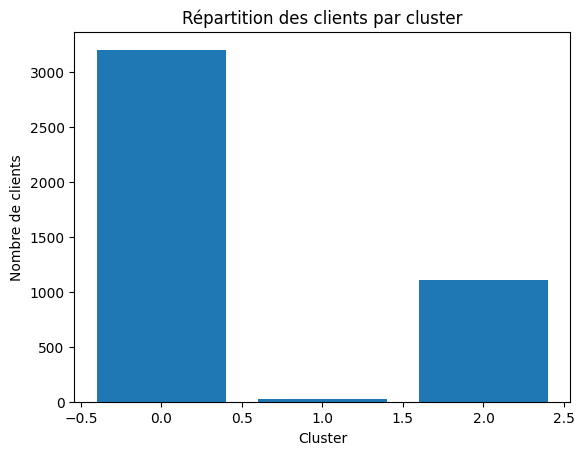

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Conversion en pandas pour visualisation
cluster_counts = df_clusters.groupBy("prediction").count().toPandas()

plt.figure()
plt.bar(cluster_counts["prediction"], cluster_counts["count"])
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")
plt.title("Répartition des clients par cluster")
plt.show()


Ce graphique montre la distribution des clients selon les clusters identifiés par l’algorithme de clustering.

On observe que le cluster 0 regroupe la majorité des clients (environ 3200), ce qui correspond probablement à des clients standards avec un comportement d’achat moyen.

Le cluster 2 contient environ 1100 clients, représentant un segment intermédiaire.

Le cluster 1 est très minoritaire (environ 25 clients), ce qui suggère un segment très spécifique, probablement composé de clients à très forte valeur (VIP).

Cette répartition met en évidence une forte hétérogénéité du portefeuille client, avec un petit groupe de clients à très forte valeur et un groupe majoritaire plus standard.


### Graphique 2 : Moyenne de Monetary par cluster

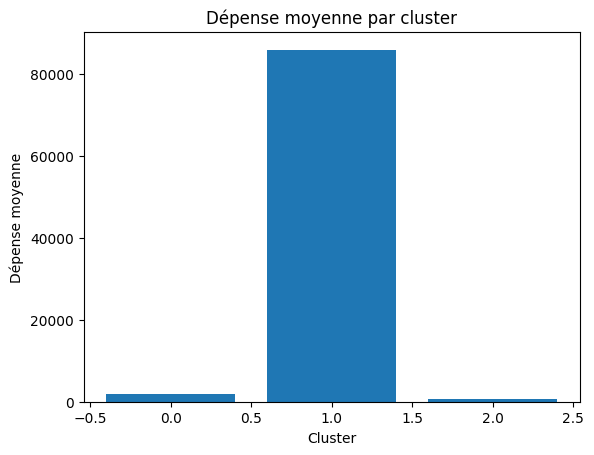

In [ ]:
cluster_monetary = df_clusters.groupBy("prediction") \
    .agg(F.mean("Monetary").alias("Moyenne_Monetary")) \
    .toPandas()

plt.figure()
plt.bar(cluster_monetary["prediction"], cluster_monetary["Moyenne_Monetary"])
plt.xlabel("Cluster")
plt.ylabel("Dépense moyenne")
plt.title("Dépense moyenne par cluster")
plt.show()


Ce graphique représente la dépense moyenne (Monetary) par cluster.

On observe une très forte différence entre les segments :

- Le cluster 1 présente une dépense moyenne extrêmement élevée (≈ 85 000€), ce qui confirme qu’il s’agit d’un segment de clients très premium / gros dépensiers.
- Le cluster 0 affiche une dépense moyenne modérée, correspondant à la majorité des clients.
- Le cluster 2 présente une dépense moyenne faible, indiquant des clients occasionnels ou à faible valeur.

Cette forte disparité valide la pertinence du clustering RFM : l’algorithme a réussi à isoler un petit groupe de clients à très forte valeur économique.

Cela constitue un levier stratégique majeur pour des actions marketing ciblées.


###  Graphique 3 — Recency moyenne par cluster

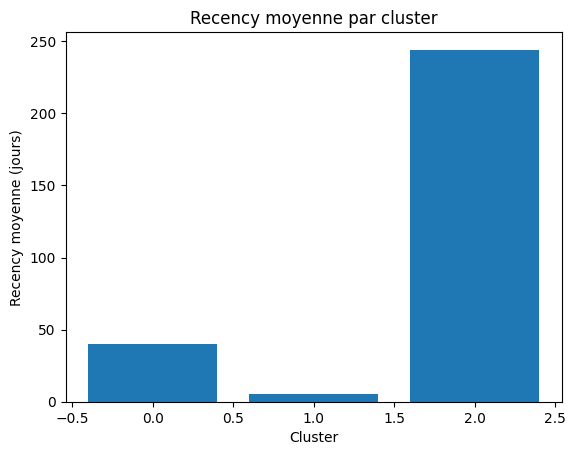

In [ ]:
# Recency moyenne par cluster
cluster_recency = df_clusters.groupBy("prediction") \
    .agg(F.mean("Recency").alias("Moyenne_Recency")) \
    .toPandas()

plt.figure()
plt.bar(cluster_recency["prediction"], cluster_recency["Moyenne_Recency"])
plt.xlabel("Cluster")
plt.ylabel("Recency moyenne (jours)")
plt.title("Recency moyenne par cluster")
plt.show()


Ce graphique présente la Recency moyenne (nombre de jours depuis la dernière commande) pour chaque cluster.

On observe une forte différence entre les segments :

- Le cluster 1 présente une Recency très faible (~5 jours) : ces clients ont acheté très récemment. Ce sont des clients actifs et engagés.
- Le cluster 0 présente une Recency intermédiaire (~40 jours) : ces clients sont relativement actifs mais moins récents.
- Le cluster 2 présente une Recency très élevée (~240 jours) : ces clients n’ont pas acheté depuis longtemps. Ils sont inactifs ou à risque de churn.

La variable Recency permet donc d’identifier clairement les clients récents, les clients réguliers et les clients à réactiver.


### Graphique 4 — Frequency moyenne par cluster

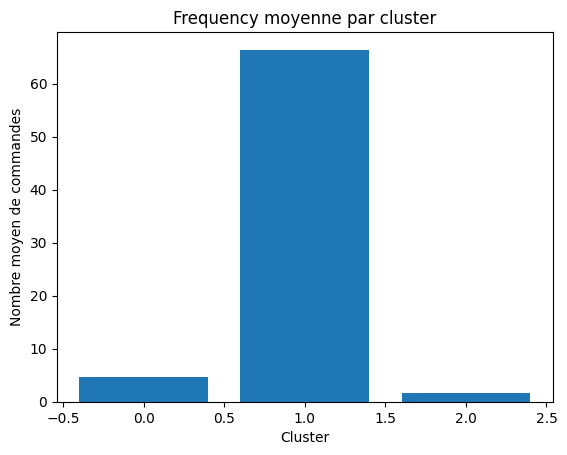

In [ ]:
# Frequency moyenne par cluster
cluster_frequency = df_clusters.groupBy("prediction") \
    .agg(F.mean("Frequency").alias("Moyenne_Frequency")) \
    .toPandas()

plt.figure()
plt.bar(cluster_frequency["prediction"], cluster_frequency["Moyenne_Frequency"])
plt.xlabel("Cluster")
plt.ylabel("Nombre moyen de commandes")
plt.title("Frequency moyenne par cluster")
plt.show()


Ce graphique représente le nombre moyen de commandes (Frequency) pour chaque cluster.

Les différences entre les segments sont très marquées :

- Le cluster 1 présente une fréquence très élevée (~66 commandes en moyenne). Ces clients achètent très régulièrement : ce sont des clients fidèles et fortement engagés.
- Le cluster 0 présente une fréquence modérée (~4 à 5 commandes). Ce sont des clients occasionnels.
- Le cluster 2 présente une fréquence très faible (~1 à 2 commandes). Il s'agit de clients peu actifs ou ayant effectué peu d’achats.

La variable Frequency confirme donc que le cluster 1 regroupe les clients les plus fidèles, tandis que le cluster 2 correspond à des clients peu engagés.


##  5.2 — Visualisation du modèle supervisé

### Étape 1 — Répartition réelle des classes

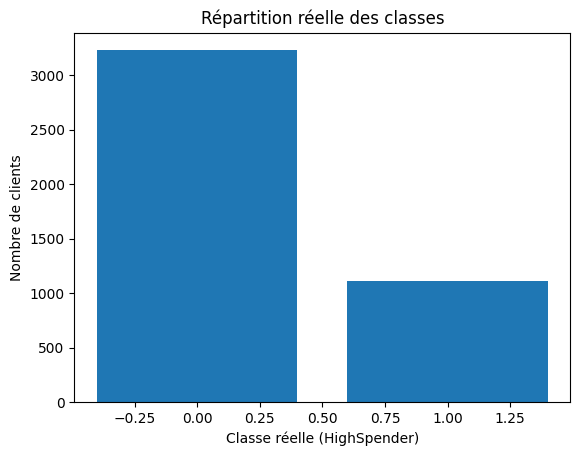

In [ ]:
# Répartition réelle des classes
real_distribution = rfm_supervised.groupBy("HighSpender").count().toPandas()

plt.figure()
plt.bar(real_distribution["HighSpender"], real_distribution["count"])
plt.xlabel("Classe réelle (HighSpender)")
plt.ylabel("Nombre de clients")
plt.title("Répartition réelle des classes")
plt.show()


Ce graphique présente la répartition réelle des clients entre les deux classes :
- 0 = Non HighSpender
- 1 = HighSpender

On observe qu’environ 75 % des clients sont classés comme non gros dépensiers,
et environ 25 % comme gros dépensiers.

Ce déséquilibre est cohérent avec le choix du seuil fixé au 75e percentile de la variable Monetary.
La classe minoritaire (HighSpender) reste néanmoins suffisamment représentée pour permettre l’entraînement d’un modèle de classification fiable.


###  Étape 2 — Répartition des prédictions du modèle

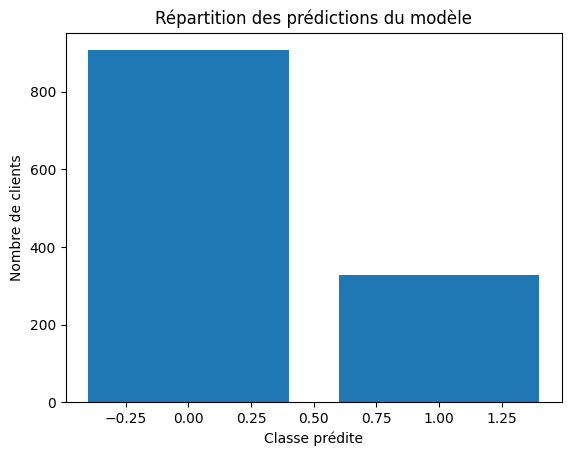

In [ ]:
# Répartition des prédictions
pred_distribution = predictions_lr_eval.groupBy("prediction").count().toPandas()

plt.figure()
plt.bar(pred_distribution["prediction"], pred_distribution["count"])
plt.xlabel("Classe prédite")
plt.ylabel("Nombre de clients")
plt.title("Répartition des prédictions du modèle")
plt.show()


Ce graphique présente la répartition des classes prédites par le modèle de régression logistique
sur le jeu de test.

On observe que le modèle prédit majoritairement la classe 0 (non HighSpender),
ce qui est cohérent avec la distribution réelle des classes observée précédemment.

La proportion de clients prédits comme HighSpender reste proche de la proportion réelle,
ce qui indique que le modèle ne semble pas biaiser fortement vers une seule classe.

Cela confirme visuellement les très bonnes performances obtenues précédemment
(accuracy, précision, recall et F1-score proches de 1).


### Etape 3 — Matrice de confusion (heatmap)

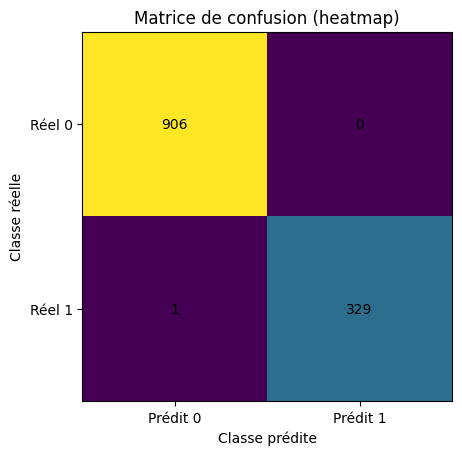

In [ ]:
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

# On récupère la matrice de confusion (comptage label vs prediction)
cm_df = (predictions_lr_eval
         .groupBy("label", "prediction")
         .count()
         .toPandas())

# On transforme en tableau 2x2
cm_pivot = (cm_df
            .pivot(index="label", columns="prediction", values="count")
            .fillna(0)
            .astype(int))

# On force l'ordre 0 puis 1 (au cas où une classe manque dans le pivot)
cm_pivot = cm_pivot.reindex(index=[0.0, 1.0], columns=[0.0, 1.0], fill_value=0)

# Heatmap "maison" (sans seaborn)
plt.figure()
plt.imshow(cm_pivot.values)

# Texte dans chaque case
for i in range(cm_pivot.shape[0]):
    for j in range(cm_pivot.shape[1]):
        plt.text(j, i, cm_pivot.values[i, j], ha="center", va="center")

plt.xticks([0, 1], ["Prédit 0", "Prédit 1"])
plt.yticks([0, 1], ["Réel 0", "Réel 1"])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion (heatmap)")
plt.show()


La matrice de confusion montre :

- 906 vrais négatifs : clients réellement "petits dépensiers" correctement classés.
- 329 vrais positifs : clients réellement "gros dépensiers" correctement classés.
- 1 faux négatif : un client réellement gros dépensier classé comme petit dépensier.
- 0 faux positif : aucun petit dépensier n’a été classé à tort comme gros dépensier.

Le modèle commet donc une seule erreur sur l’ensemble du jeu de test (1236 observations).

Cela explique les performances extrêmement élevées obtenues précédemment :
accuracy, précision, recall et F1-score ≈ 0.999.

Le modèle semble donc parfaitement séparer les deux classes.


### Étape 4 — Probabilité moyenne prédite

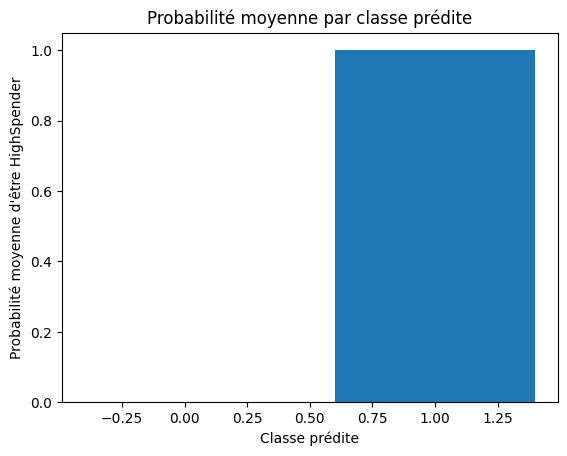

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

# Convertir le vecteur "probability" en array, puis prendre la proba de la classe 1
pred_prob = predictions_lr_eval.withColumn(
    "proba_1",
    vector_to_array(F.col("probability"))[1]
)

# Moyenne de la proba de classe 1 par classe prédite
proba_avg = (pred_prob.groupBy("prediction")
             .agg(F.mean("proba_1").alias("Moyenne_Proba_Classe1"))
             .orderBy("prediction")
             .toPandas())

plt.figure()
plt.bar(proba_avg["prediction"], proba_avg["Moyenne_Proba_Classe1"])
plt.xlabel("Classe prédite")
plt.ylabel("Probabilité moyenne d'être HighSpender")
plt.title("Probabilité moyenne par classe prédite")
plt.show()


Ce graphique montre la probabilité moyenne d’être classé "HighSpender"
pour chaque classe prédite par le modèle.

On observe que :

- Pour la classe prédite 1 (HighSpender), la probabilité moyenne est très proche de 1.
- Le modèle est donc extrêmement confiant lorsqu’il prédit qu’un client est un gros dépensier.

Cela confirme les très bonnes performances observées précédemment
(accuracy, précision, recall et F1-score très élevés).

Le modèle ne se contente pas de prédire correctement,
il est également très sûr de ses décisions.


## 5.3 — Recommandations business


###  Recommandations basées sur le clustering (RFM)

L’analyse RFM a permis d’identifier trois profils de clients :

- **Cluster 1 : Gros dépensiers**  
  Clients récents, fréquents et avec un montant élevé.  
   Recommandation : programme VIP, offres exclusives, fidélisation premium.

- **Cluster 0 : Clients intermédiaires**  
  Clients réguliers avec une dépense modérée.  
   Recommandation : promotions ciblées pour augmenter le panier moyen et la fréquence d’achat.

- **Cluster 2 : Clients inactifs / occasionnels**  
  Faible fréquence et dernière commande ancienne.  
   Recommandation : campagnes de relance (email, code promo personnalisé, offre limitée).



###  Recommandations basées sur le modèle supervisé

Le modèle de classification permet de prédire si un client est un **HighSpender**.

Les performances obtenues (accuracy, precision, recall et F1-score proches de 1) montrent que le modèle est très performant.

 Utilisation possible :
- Calculer le score d’un client en temps réel
- Adapter les offres marketing selon la probabilité d’être gros dépensier
- Intégrer le modèle dans un CRM ou un pipeline marketing



###  Conclusion

La combinaison du **clustering (segmentation)** et du **modèle prédictif** permet :

- Une meilleure compréhension des profils clients  
- Une optimisation des campagnes marketing  
- Une augmentation potentielle du chiffre d’affaires  


# 6- Conclusion


##  Résumé des travaux réalisés

Dans ce projet, nous avons analysé un jeu de données transactionnelles afin de mieux comprendre le comportement des clients.

Les principales étapes ont été :

- Nettoyage et préparation des données
- Construction des variables RFM (Recency, Frequency, Monetary)
- Segmentation des clients via un algorithme de clustering (K-Means)
- Construction d’un modèle supervisé (régression logistique) pour prédire les HighSpenders
- Évaluation des performances à l’aide de métriques adaptées et de visualisations

Cette approche a permis de combiner analyse exploratoire, segmentation et prédiction.



## Apports du projet

Les résultats obtenus permettent :

- D’identifier clairement différents profils de clients
- De détecter les clients à forte valeur
- D’anticiper les comportements d’achat futurs
- D’optimiser les campagnes marketing
- D’améliorer la prise de décision basée sur les données

La combinaison du clustering et du modèle prédictif constitue une approche complète et cohérente.



## Limites de l’analyse

Certaines limites doivent néanmoins être soulignées :

- La variable "Monetary" est utilisée pour définir le label "HighSpender", ce qui peut expliquer les performances très élevées du modèle.
- Le clustering dépend du choix du nombre de clusters (k).
- Le dataset ne contient pas d’informations démographiques ou comportementales plus fines.
- L’analyse repose uniquement sur les données transactionnelles disponibles.



## Perspectives d’amélioration

Pour aller plus loin, plusieurs pistes peuvent être envisagées :

- Tester d’autres modèles supervisés (Random Forest, Gradient Boosting)
- Ajouter de nouvelles variables explicatives
- Mettre en place une validation croisée plus approfondie
- Intégrer le modèle dans un système opérationnel (CRM, pipeline marketing)




## Conclusion générale

Ce projet illustre l’intérêt des techniques de Big Data et de Machine Learning
pour segmenter une base client et prédire les comportements d’achat.

L’approche proposée permet à une entreprise de mieux comprendre ses clients,
d’optimiser ses actions marketing et d’augmenter sa performance commerciale
grâce à une stratégie basée sur les données.

